In [1]:
include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("../doa/music.jl") # MUSIC

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [2]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

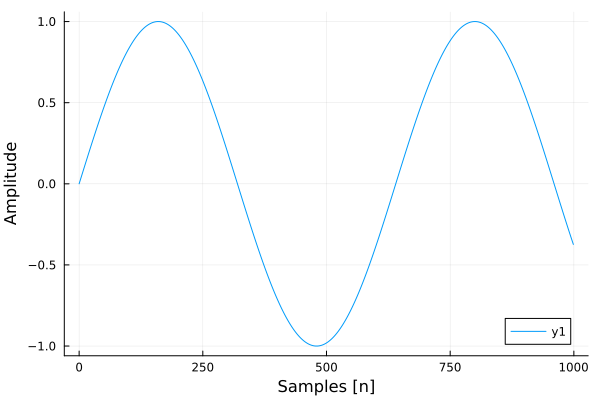

In [71]:
using Plots
plot(n[1:1000], tone_sig[1:1000, 1])
xlabel!("Samples [n]")
ylabel!("Amplitude")

In [72]:
# Note: Please use Floating Point Numbers for Azimuth Angles
include("../signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;     # Ground Truth Azimuth Angle (in degrees)
c0 = 1500;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, az_gt2, c0); 
new_sig = sig1 + sig2;


Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.872651 seconds (1.21 k allocations: 595.776 MiB)
Now Generated Signal has size: (320000, 40)
Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  1.015867 seconds (1.21 k allocations: 595.776 MiB)
Now Generated Signal has size: (320000, 40)


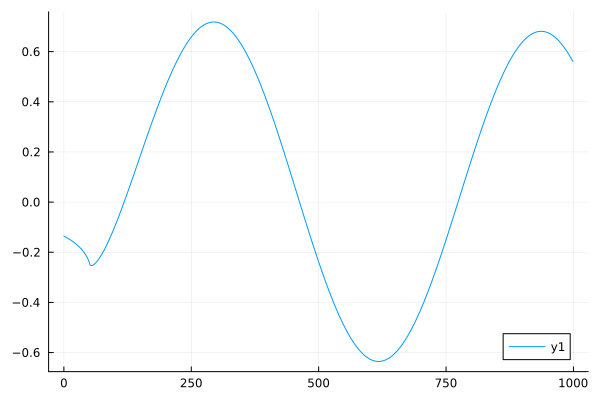

In [86]:
start = 1;
ending = 1000;
plot(n[start:ending], real(sig1[start:ending, 1]))

In [4]:
# Add Noise
using Random
using DSP: db2amp
using SignalAnalysis: PinkGaussian
rng = Random.seed!(1234);
noise_pow = 0; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2))
rng = Random.seed!(1234);
pink_noise = rand(rng, PinkGaussian(size(new_sig, 1), 2.0));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;
noisy_sig1 = sig1 + db2amp(noise_pow) .* noise;
noisy_sig2 = sig2 + db2amp(noise_pow) .* noise;

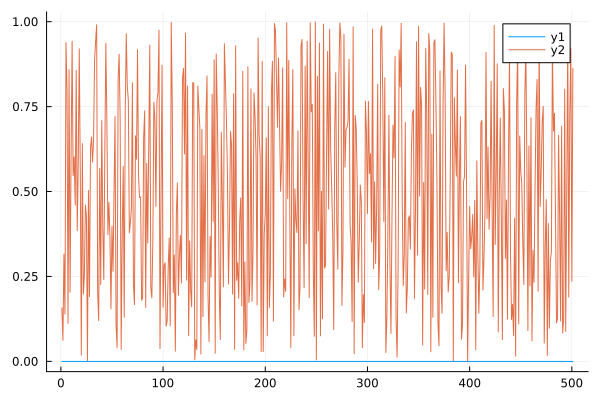

In [14]:
using Plots
T_plot = 500;
start = 64000;
plot(real(new_sig[start:start+T_plot,1]))
plot!(real(noisy_sig[start:start+T_plot,1]))

In [21]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
function filter_freq_per_ch(new_sig, freq_interest)
# freq_interest = freq; # (Hz)
    new_S = []
    NFFT = size(new_sig, 1);
    frequencies = sample_rate/NFFT*(0:(NFFT-1));
    (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );

    for signal in eachcol(new_sig)
        S_interest = fft(signal);
        S_interest = S_interest[freq_idx];
        push!(new_S, S_interest);
    end
    return new_S
end

new_S = filter_freq_per_ch(new_sig, freq);
new_S1 = filter_freq_per_ch(sig1, freq);
new_S2 = filter_freq_per_ch(sig2, freq);

In [23]:
Rx = (1 ./ 1) .* new_S * new_S';
order = 3;
@time P_cbf, az_list = cbf(Rx, sensors_underwater, freq, c0)
@time P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq, c0)
Rx1 = (1 ./ 1) .* new_S1 * new_S1';
@time P1_cbf, az_list = cbf(Rx1, sensors_underwater, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors_underwater, order, freq, c0)
Rx2 = (1 ./ 1) .* new_S2 * new_S2';
@time P2_cbf, az_list = cbf(Rx2, sensors_underwater, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors_underwater, order, freq, c0)

  0.271786 seconds (915.08 k allocations: 48.854 MiB, 98.19% compilation time)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1


ψ has rank 7
  2.168136 seconds (5.92 M allocations: 292.299 MiB, 99.60% compilation time)


  0.007041 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.003220 seconds (13.36 k allocations: 1.106 MiB)
  0.004718 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.004084 seconds (13.36 k allocations: 1.105 MiB)


([5.224457976270708e6, 6.178499150449514e6, 7.133284645895482e6, 8.0716288064053e6, 8.977719257777233e6, 9.837209422013057e6, 1.0637293473115386e7, 1.136676345760296e7, 1.2016048489384407e7, 1.2577236108260993e7  …  19319.565650487697, 33108.51931521404, 241053.6763441884, 620301.427326944, 1.1478827741104872e6, 1.8009223309117963e6, 2.556839987017062e6, 3.393543505251564e6, 4.289610450251548e6, 5.224457976273569e6], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … -0.000202821959874734 - 0.000947628789081802im -0.0007655650718008316 - 0.00024881805381223124im; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 - 0.014914890292374024im -0.004392940862485556 - 0.01352265060754891im; … ; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 + 0.014914890292374024im -0.004392940862485556 + 0.01352265060754891im; 0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959

In [24]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)

([0.020408019636390804, 0.02413473944254081, 0.027864366750886257, 0.0315297701554795, 0.03506918262810965, 0.0384265629015615, 0.041551888265421486, 0.04440137769287912, 0.046937644945557626, 0.04912978200508622  …  7.546698182901886e-5, 0.00012933003105501515, 0.0009416150311860576, 0.0024230501550336473, 0.004483912838560794, 0.00703484619070429, 0.009987646737547358, 0.013256016759379879, 0.016756274947337182, 0.02040801963640198], 120.0)

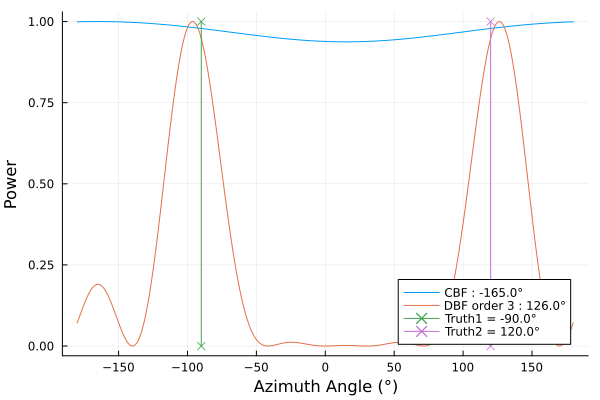

In [25]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

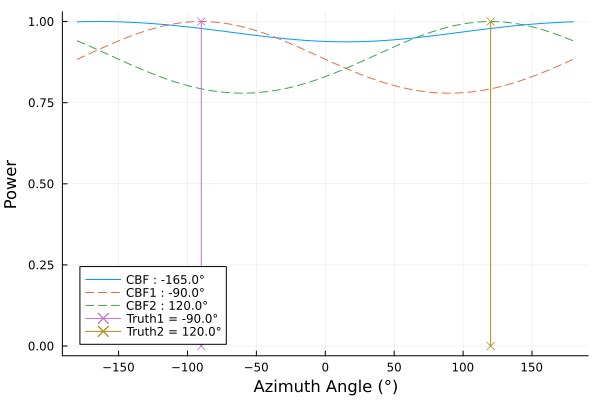

In [26]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

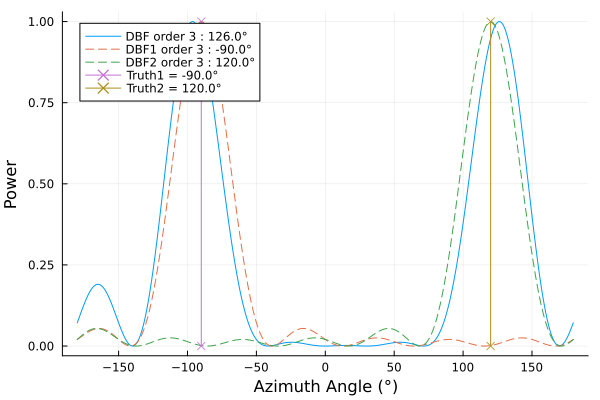

In [27]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

In [30]:
noisy_S = filter_freq_per_ch(noisy_sig, freq);
noisy_S1 = filter_freq_per_ch(noisy_sig1, freq);
noisy_S2 = filter_freq_per_ch(noisy_sig2, freq);

noisy_Rx = (1 ./ 1) .* noisy_S * noisy_S';
order = 3;
@time Pn_cbf, az_list = cbf(noisy_Rx, sensors_underwater, freq, c0)
@time Pn_dbf, az_list = dbf_coFree(noisy_Rx, sensors_underwater, order, freq, c0)
noisy_Rx1 = (1 ./ 1) .* noisy_S1 * noisy_S1';
@time P1n_cbf, az_list = cbf(noisy_Rx1, sensors_underwater, freq, c0)
@time P1n_dbf, az_list = dbf_coFree(noisy_Rx1, sensors_underwater, order, freq, c0)
noisy_Rx2 = (1 ./ 1) .* noisy_S2 * noisy_S2';
@time P2n_cbf, az_list = cbf(noisy_Rx2, sensors_underwater, freq, c0)
@time P2n_dbf, az_list = dbf_coFree(noisy_Rx2, sensors_underwater, order, freq, c0)

  0.002317 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.004315 seconds (13.36 k allocations: 1.106 MiB)
  0.002348 seconds (15.90 k allocations: 1.631 MiB)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001668 seconds (13.40 k allocations: 1.110 MiB)
  0.002391 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001487 seconds (13.36 k allocations: 1.106 MiB)


([6.025555564869242e7, 6.3890022383657716e7, 6.822960710023275e7, 7.31926151031296e7, 7.869324850398844e7, 8.464253159154628e7, 9.094925695728628e7, 9.752094257872625e7, 1.0426479001497832e8, 1.1108863391848147e8  …  6.965552624904892e7, 6.434824288973503e7, 6.016608521678351e7, 5.709801989037283e7, 5.512297968022704e7, 5.42102182449528e7, 5.431975556126323e7, 5.540290890279051e7, 5.740290342660464e7, 6.025555564868597e7], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … -0.000202821959874734 - 0.000947628789081802im -0.0007655650718008316 - 0.00024881805381223124im; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 - 0.014914890292374024im -0.004392940862485556 - 0.01352265060754891im; … ; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 + 0.014914890292374024im -0.004392940862485556 + 0.01352265060754891im; 0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087

In [31]:
Pn_cbf_norm, n_az_cbf_max = normalize_P(Pn_cbf, az_list)
Pn_dbf_norm, n_az_dbf_max = normalize_P(Pn_dbf, az_list)
P1n_cbf_norm, n_az1_cbf_max = normalize_P(P1n_cbf, az_list)
P1n_dbf_norm, n_az1_dbf_max = normalize_P(P1n_dbf, az_list)
P2n_cbf_norm, n_az2_cbf_max = normalize_P(P2n_cbf, az_list)
P2n_dbf_norm, n_az2_dbf_max = normalize_P(P2n_dbf, az_list)

([0.1315634187126798, 0.1394990001491431, 0.14897415302026754, 0.15981050317802545, 0.1718207174646785, 0.1848105241880959, 0.1985807789150845, 0.21292955418988965, 0.22765423168125581, 0.24255357536901143  …  0.15208753893143373, 0.14049948974142676, 0.13136806683568, 0.12466917975662306, 0.12035682981072346, 0.11836388470216104, 0.11860305109362931, 0.120968033958151, 0.1253348697482602, 0.1315634187126657], 138.0)

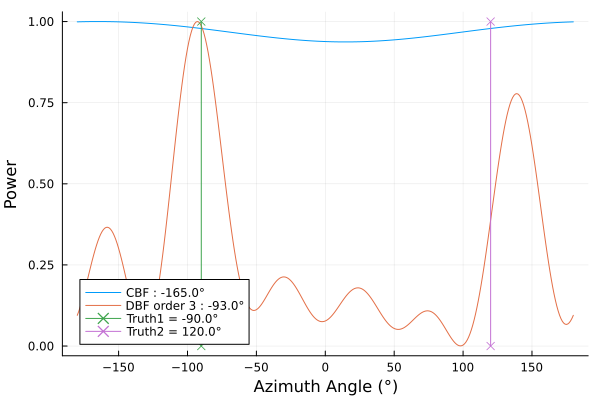

In [32]:
plot(az_list, Pn_cbf_norm, label="CBF : $(n_az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

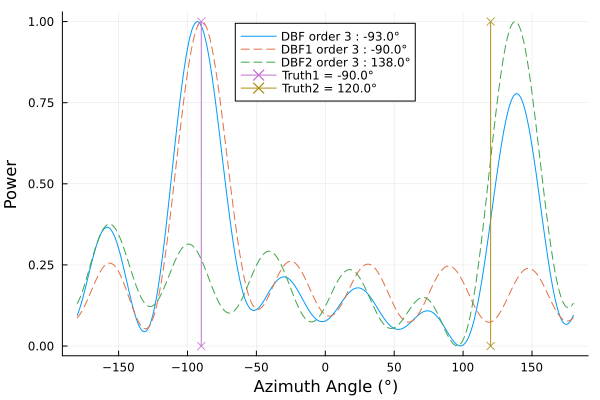

In [35]:
plot(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1n_dbf_norm, label="DBF1 order $order : $(n_az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2n_dbf_norm, label="DBF2 order $order : $(n_az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

In [58]:
include("../doa/mdbf.jl")

wng_pow=db2pow(0);
@time P_mdbf, az_list = mdbf(Rx, sensors_underwater, order, freq, c0, wng_pow);
@time P1_mdbf, az_list = mdbf(Rx1, sensors_underwater, order, freq, c0, wng_pow);
@time P2_mdbf, az_list = mdbf(Rx2, sensors_underwater, order, freq, c0, wng_pow);

P_mdbf_norm, az_mdbf_max = normalize_P(P_mdbf, az_list);
P1_mdbf_norm, az1_mdbf_max = normalize_P(P1_mdbf, az_list);
P2_mdbf_norm, az2_mdbf_max = normalize_P(P2_mdbf, az_list);

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.893221 seconds (2.60 M allocations: 271.838 MiB, 24.12% compilation time)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.727774 seconds (1.87 M allocations: 237.982 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.968664 seconds (1.87 M allocations: 237.982 MiB, 20.54% gc time)


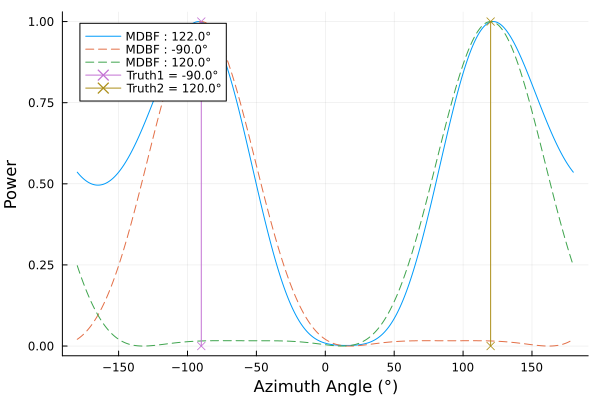

In [59]:
plot(az_list, P_mdbf_norm, label="MDBF : $(az_mdbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1_mdbf_norm, label="MDBF : $(az1_mdbf_max)°",
        linestyle=:dash)
plot!(az_list, P2_mdbf_norm, label="MDBF : $(az2_mdbf_max)°",
        linestyle=:dash)
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

In [65]:
wng_pow=db2pow(noise_pow);
@time Pn_mdbf, az_list = mdbf(noisy_Rx, sensors_underwater, order, freq, c0, wng_pow);
@time P1n_mdbf, az_list = mdbf(noisy_Rx1, sensors_underwater, order, freq, c0, wng_pow);
@time P2n_mdbf, az_list = mdbf(noisy_Rx2, sensors_underwater, order, freq, c0, wng_pow);

Pn_mdbf_norm, n_az_mdbf_max = normalize_P(Pn_mdbf, az_list);
P1n_mdbf_norm, n_az1_mdbf_max = normalize_P(P1n_mdbf, az_list);
P2n_mdbf_norm, n_az2_mdbf_max = normalize_P(P2n_mdbf, az_list);

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.735458 seconds (1.87 M allocations: 237.981 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.822708 seconds (1.87 M allocations: 237.981 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.801200 seconds (1.87 M allocations: 237.981 MiB)


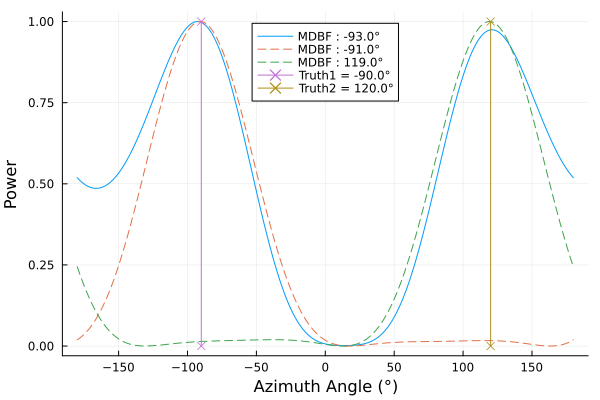

In [66]:
plot(az_list, Pn_mdbf_norm, label="MDBF : $(n_az_mdbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1n_mdbf_norm, label="MDBF : $(n_az1_mdbf_max)°",
        linestyle=:dash)
plot!(az_list, P2n_mdbf_norm, label="MDBF : $(n_az2_mdbf_max)°",
        linestyle=:dash)
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°",
        legend=:top)